In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

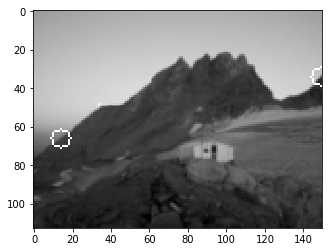

In [2]:
ridge_start_row = 66
ridge_start_col = 14
ridge_end_row = 34
ridge_end_col = 149

im = cv2.imread("mountain.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = cv2.normalize(im.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
im = cv2.GaussianBlur(im, (7,7), 0.5)

im_temp = np.copy(im)
cv2.circle(im_temp, (ridge_start_col, ridge_start_row), 5, (1,1,1))
cv2.circle(im_temp, (ridge_end_col, ridge_end_row), 5, (1,1,1))

plt.figure()
plt.imshow(im_temp, cmap="gray")

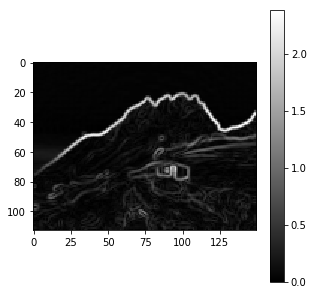

In [3]:
grad_x = cv2.Sobel(im, cv2.CV_64F, 1, 0, 3)
grad_y = cv2.Sobel(im, cv2.CV_64F, 0, 1, 3)
grad_mag = np.sqrt(grad_x * grad_x + grad_y * grad_y)

plt.figure(figsize=(5,5))
plt.imshow(grad_mag, cmap="gray")
plt.colorbar()

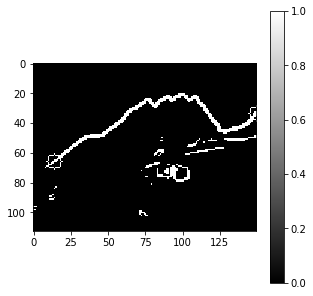

In [5]:
thresholded_grad = np.copy(grad_mag)
thresholded_grad[thresholded_grad <  0.7] = 0
thresholded_grad[thresholded_grad >= 0.7] = 1

im_temp = np.copy(thresholded_grad)
cv2.circle(im_temp, (ridge_start_col, ridge_start_row), 5, (1,1,1))
cv2.circle(im_temp, (ridge_end_col, ridge_end_row), 5, (1,1,1))

plt.figure(figsize=(5,5))
plt.imshow(im_temp, cmap="gray")
plt.colorbar()

In [17]:
def dijkstra(edge_map, C, ridge_start_row, ridge_start_col):
        
    thresholded_grad = np.copy(edge_map)
        
    edge_cost = C - thresholded_grad;        # cost of passing through a pixel    
    num_rows = np.shape(thresholded_grad)[0] # row of input image
    num_cols = np.shape(thresholded_grad)[1] # col of input image

    # distance image (the distance from the start point, to the current location)
    distance_mask  = np.full(shape=(num_rows,num_cols),   fill_value=np.inf)
    
    # visited pixels
    visited_pixels = np.full(shape=(num_rows,num_cols),   fill_value=0)
    
    # stores for each pixel, the [row,col] of the previous pixel
    previous_pixel = np.full(shape=(num_rows,num_cols,2), fill_value=0)      
    
    # initialize distance to starting point to be 0
    distance_mask[ridge_start_row, ridge_start_col] = 0
    
    # we will visit every single pixel in the edge map
    while(np.sum(visited_pixels) < num_rows * num_cols):
        
        # 1. set pixels that have already been visited to infinity as to avoid 
        #    visiting them again since in 2, we locate the pixel with the
        #    smallest distance
        active_distances = np.copy(distance_mask)
        active_distances[visited_pixels == 1] = np.inf
        
        # 2. locate the minimum distance and its row,col position
        cur_row, cur_col = np.unravel_index(active_distances.argmin(), active_distances.shape)
        cur_dist = active_distances[cur_row, cur_col]
        
        # 3. set current position to visited
        visited_pixels[cur_row, cur_col] = 1;
        
        # Now update the distance_mask and previous_pixel for all neighbours (i, j)
        # of current pixel based on the condition:
        # distance_mask(i, j) > distance_mask(cur_row, cur_pos) + edge_cost(i, j)
        # This condition is important because pixels that have been visited would
        # have a distance that is smaller
        
        # You should have here 4 similar statements for pixel above, below, to the
        # left and to the right of (cur_row, cur_col).
        # Remember to check if you are getting outside of the array bounds

        if (cur_row > 0 and distance_mask[cur_row - 1, cur_col] > cur_dist + edge_cost[cur_row - 1, cur_col]):
            previous_pixel[cur_row - 1, cur_col, 0] = cur_row
            previous_pixel[cur_row - 1, cur_col, 1] = cur_col
            distance_mask[cur_row - 1, cur_col]= cur_dist + edge_cost[cur_row - 1, cur_col]
            
        if (cur_row < num_rows - 1 and distance_mask[cur_row + 1, cur_col] > cur_dist + edge_cost[cur_row + 1, cur_col]):
            previous_pixel[cur_row + 1, cur_col, 0] = cur_row
            previous_pixel[cur_row + 1, cur_col, 1] = cur_col
            distance_mask[cur_row + 1, cur_col] = cur_dist + edge_cost[cur_row + 1, cur_col]

        if (cur_col > 0 and distance_mask[cur_row, cur_col - 1] > cur_dist + edge_cost[cur_row, cur_col - 1]):
            previous_pixel[cur_row, cur_col - 1, 0] = cur_row
            previous_pixel[cur_row, cur_col - 1, 1] = cur_col
            distance_mask[cur_row, cur_col - 1] = cur_dist + edge_cost[cur_row, cur_col - 1]

        if (cur_col < num_cols - 1 and distance_mask[cur_row, cur_col + 1] > cur_dist + edge_cost[cur_row, cur_col + 1]):
            previous_pixel[cur_row, cur_col + 1, 0] = cur_row
            previous_pixel[cur_row, cur_col + 1, 1] = cur_col
            distance_mask[cur_row, cur_col + 1] = cur_dist + edge_cost[cur_row, cur_col + 1]

    return distance_mask, previous_pixel

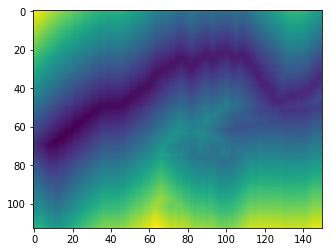

In [18]:
distance_mask, previous_pixel = dijkstra(thresholded_grad, 1.05, ridge_start_row, ridge_start_col)
recovered_path = np.zeros(shape=np.shape(distance_mask))
plt.imshow(distance_mask)

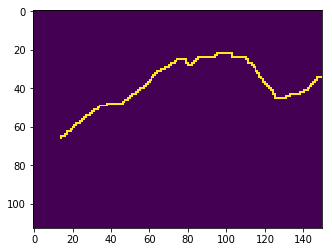

In [20]:
cur_row = ridge_end_row
cur_col = ridge_end_col
recovered_path[cur_row, cur_col] = 1
while(cur_row != ridge_start_row or cur_col != ridge_start_col):
    prev_row = previous_pixel[cur_row, cur_col, 0]
    prev_col = previous_pixel[cur_row, cur_col, 1]
    cur_row = prev_row
    cur_col = prev_col
    recovered_path[cur_row, cur_col] = 1
    
img_with_ridge = np.copy(im)
img_with_ridge[recovered_path > 0] = 255
plt.figure()
plt.imshow(img_with_ridge)